<a href="https://colab.research.google.com/github/iamviji/project/blob/master/MainModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!rm -rf project
!git clone https://github.com/iamviji/project.git
!ls
!ls project
!pip install pyldpc
!pip install scikit-commpy



Cloning into 'project'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 17 (delta 2), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (17/17), done.
project  sample_data
MainModel.ipynb  README.md  util.py


In [15]:
import pyldpc
import commpy
import numpy as np
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

In [16]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 3
num_bits_in_parity_check = 6 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [17]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

init = tf.global_variables_initializer ()
sess = tf.Session ()
sess.run(init)

def AWGNChannelOutput (xx, snr , s):
  sigma = Snr2Sigma (snr)
  awgn_channel_output_message = s.run ([awgn_channel_output], feed_dict={noise_std_dev:sigma, channel_input:xx})
  return awgn_channel_output_message

In [18]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = np.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 11 channel_size= 18
input_message_size= 11 channel_size= 18
[[0 0 1 ... 1 0 1]
 [0 1 1 ... 0 0 1]
 [0 1 0 ... 1 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [1 0 0 ... 1 0 1]
 [0 0 0 ... 0 1 1]]


This section tries to compare BER and Time performance of PYLDPC in following 3 cases
1. SNR Noise function provided in encoder function of pyldpc library (pyldpc.encode)
2. SNR Noise function provided by commpy library (commpy.channels.awgn) 
3. SNR Noise function implemented using tensorflow 

In [19]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_tensor  = np.array(())
times_per_iter_tensor = np.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    sigma = Snr2Sigma (snr)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})[0]
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      #print ("count=",abs(decoded_message-input_message[i]).sum())
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_tensor=np.append(ber_per_iter_tensor ,ber)
  times_per_iter_tensor=np.append(times_per_iter_tensor, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.71s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.24s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.78s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.38s
SNR: 0.000:
 -> BER: 0.61
 -> Total Time: 16.11s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.38s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.86s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.30s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.63s
SNR: 0.500:
 -> BER: 0.52
 -> Total Time: 14.17s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.16s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.27s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.38s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.50s
SNR: 1.000:
 -> BER: 0.43
 -> Total Time: 11.32s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.91s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.72s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [20]:
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_awgn  = np.array(())
times_per_iter_awgn = np.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    awgn_channel_output_message = commpy.channels.awgn(encoded_message, snr)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_awgn=np.append(ber_per_iter_awgn ,ber)
  times_per_iter_awgn=np.append(times_per_iter_awgn, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.53s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 2.94s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.47s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 5.94s
SNR: 0.000:
 -> BER: 0.62
 -> Total Time: 14.88s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.38s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.61s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.90s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.09s
SNR: 0.500:
 -> BER: 0.54
 -> Total Time: 12.99s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.00s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.04s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.07s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.13s
SNR: 1.000:
 -> BER: 0.46
 -> Total Time: 10.25s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.90s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.62s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [21]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_pyldpc  = np.array(())
times_per_iter_pyldpc = np.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_pyldpc=np.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=np.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.51s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.07s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.70s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.32s
SNR: 0.000:
 -> BER: 0.63
 -> Total Time: 15.60s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.25s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.60s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.66s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 4.95s
SNR: 0.500:
 -> BER: 0.52
 -> Total Time: 12.46s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.92s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.90s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 2.94s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.00s
SNR: 1.000:
 -> BER: 0.46
 -> Total Time: 9.75s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.88s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.59s
SNR: 1.500 - Iter: 750 - Last 250.0 ite

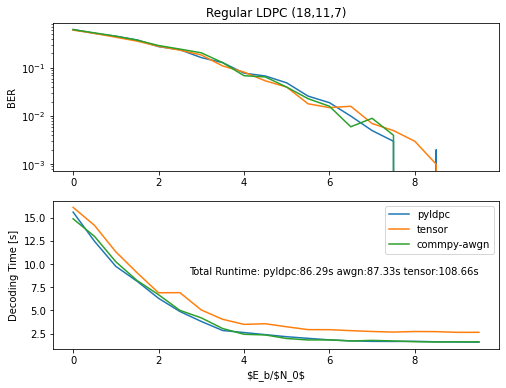

In [22]:
# Compare 3 AWGN(Tensorflow, CommPy, PYLDPC) Simulation on LDPC
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="tensor") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_awgn,'', label="commpy-awgn") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(np.sum(times_per_iter_pyldpc), 
            np.sum(times_per_iter_awgn), np.sum(times_per_iter_tensor)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

<B>Conclussion:</B>
      It proved that tensorflow behaves similar to AWGN noise channel provided by pyldpc, commpy. But tensor flow based one takes adds little more time delay. This need to be offseted if we are comparing performance. 

In [62]:
# Define Model 

# input_message_length is initialized by ldpc encoder
num_hidden_1 = CHANEL_SIZE
print ("input_message_length=", input_message_length)
input_message_x = tf.placeholder("float32", [None, input_message_length], name="input_message_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length, num_hidden_1], -1, 1), name="encoder_l1_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1, input_message_length], -1, 1), name="decoder_l1_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l1_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l1_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.sigmoid (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  return layer_1

def dl_decoder (x):
  layer_1 = tf.nn.sigmoid (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  return layer_1

def awgn_layer(x):
  awgn_noise_std_dev = tf.compat.v1.placeholder(dtype=tf.float32, name ="awgn_noise_std_dev")
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  awgn_channel_output = x
  return awgn_channel_output

dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
dl_decoder_output = dl_decoder (dl_decoder_input)

input_channel_x = tf.placeholder("float32", [None, CHANEL_SIZE], name="input_channel_x")
dl_decoder_only_output = dl_decoder(input_channel_x)


loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))
learning_rate = 0.1
rms_optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize (loss1)


input_message_length= 11


In [70]:
batch_size = 250
training_input_message = np.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 1
display_step = 20
num_of_batches = len(training_input_message) / batch_size
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
for snr in numpy.arange (SNR_BEGIN, 3, SNR_STEP_SIZE):
  sigma = 1.0*Snr2Sigma (snr)
  print ("Training for SNR=", snr, " sigma=", sigma) 
  for j in range (int(num_of_batches)):
    x_train_batch = training_input_message [j*batch_size:(j+1)*batch_size]
    x_train_batch_float = x_train_batch.astype("float32")
    _, l = train_sess.run ([rms_optimizer, loss1], feed_dict={input_message_x:x_train_batch_float, awgn_noise_std_dev:sigma})
    if j % display_step == 0:
        print('Step %i: Minibatch Loss: %f' % (i*display_step+j, l))

[[0 1 1 ... 1 0 0]
 [0 0 0 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 ...
 [0 1 0 ... 0 1 0]
 [1 1 0 ... 1 0 1]
 [1 0 0 ... 1 1 0]]
10000
batch_size: 250 num_of_batcches: 40.0
Training for SNR= 0.0  sigma= 1.0
Step 19980: Minibatch Loss: 0.833565
Step 20000: Minibatch Loss: 0.726195
Training for SNR= 0.5  sigma= 0.9440608762859234
Step 19980: Minibatch Loss: 0.661218
Step 20000: Minibatch Loss: 0.595139
Training for SNR= 1.0  sigma= 0.8912509381337456
Step 19980: Minibatch Loss: 0.495410
Step 20000: Minibatch Loss: 0.330609
Training for SNR= 1.5  sigma= 0.8413951416451951
Step 19980: Minibatch Loss: 0.194004
Step 20000: Minibatch Loss: 0.085806
Training for SNR= 2.0  sigma= 0.7943282347242815
Step 19980: Minibatch Loss: 0.051548
Step 20000: Minibatch Loss: 0.031576
Training for SNR= 2.5  sigma= 0.7498942093324559
Step 19980: Minibatch Loss: 0.015764
Step 20000: Minibatch Loss: 0.010955


In [91]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = np.array(())
times_per_iter_dl_tensor = np.array(())

for snr in numpy.arange (SNR_BEGIN, 3, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    print ("input", input_message[i])
    print ("input", decoded_message[0][0])
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=np.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=np.append(times_per_iter_dl_tensor, total_time)

Streaming output truncated to the last 5000 lines.
 2.3509289e-08 1.8052644e-01 9.9673522e-01 3.8873359e-06 7.4246389e-05
 1.0000000e+00]
input [1 1 1 0 0 0 0 0 0 1 1]
input [1.6056895e-03 9.9999499e-01 2.3694965e-01 9.9999058e-01 9.2184210e-01
 2.1823346e-12 9.5859170e-04 9.2338192e-01 1.5653640e-02 9.9999499e-01
 9.9752200e-01]
input [0 1 0 0 0 1 1 1 0 0 0]
input [3.0547380e-04 9.9923146e-01 9.9999154e-01 8.0155206e-01 9.9999905e-01
 9.9153572e-01 1.5065659e-06 1.6645491e-03 2.1224141e-11 9.9999523e-01
 1.6742945e-04]
input [0 1 0 0 0 0 1 0 1 1 0]
input [3.9632732e-06 9.9999940e-01 1.0000000e+00 4.4641332e-05 3.3276975e-03
 9.9177837e-01 1.0000000e+00 9.9999988e-01 9.9701756e-01 1.0000000e+00
 4.6428889e-07]
input [0 0 1 0 1 1 0 1 0 0 1]
input [4.0986947e-09 2.9516838e-07 2.2938848e-04 1.4190286e-02 7.1865629e-09
 9.4441164e-01 9.6449949e-12 3.1743407e-02 5.5241585e-04 6.7867234e-08
 1.0000000e+00]
input [1 1 0 1 1 1 0 1 1 0 1]
input [1.0000000e+00 9.9999738e-01 1.3550520e-03 5.34359

KeyboardInterrupt: ignored